In [3]:
import numpy as np
from scipy.fft import fft, fftfreq

class NoiseGenerator:
    """Generates gaussian noise with a specified power spectral density.
    Noise is generated by first creating a gaussian white base noise in the
    frequency domain, and then shaping it using a colouring function. Various
    colouring functions are provided for convenience.
    Examples
    --------
    >>> ng = NoiseGenerator()
    Generate 100000 white noise points sampled at 1 kHz with a PSD of 0.1.
    >>> white = ng.generate(1e-3, 100000, colour=ng.white(0.1))
    Generate some other colours of noise at a sampling rate of 1 MHz.
    >>> pink = ng.generate(1e-6, 1000000, colour=ng.pink(10.0))
    >>> blue = ng.generate(1e-6, 1000000, colour=ng.blue())
    Use a custom piecewise colouring function to generate specific noise.
    >>> frequencies = [90.0, 100.0, 110.0, 450.0, 500.0, 550.0]
    >>> psds = [0.1, 10.0, 0.01, 0.01, 2.0, 0.001]
    >>> colour = ng.piecewise_logarithmic(frequencies, psds)
    >>> custom = ng.generate(1e-4, 1000000, colour=colour)
    """

    rng = np.random.default_rng()

    def generate(self, dt, n, colour=None):
        """Generates uniformly sampled noise of a particular colour.
        Parameters
        ----------
        dt : float
            Sampling period, in seconds.
        n : int
            Number of samples to generate.
        colour : function, optional
            Colouring function that specifies the PSD at a given frequency. If
            not specified, the noise returned will be white Gaussian noise with
            a PSD of 1.0 across the entire frequency range.
        Returns
        -------
        numpy.array
            Length `n` array of sampled noise.
        """

        f, x_f = self._base_noise(dt, n)

        if colour:
            x_f *= np.sqrt(colour(f))

        return np.fft.irfft(x_f)

    @staticmethod
    def white(scale=1.0):
        """Creates a white noise colouring function.
        Parameters
        ----------
        scale : float, optional
            Multiplier to adjust the scale of the white noise.
        Returns
        -------
        function
            White noise colouring function that can be used with `generate()`.
            The function returned will be :math:`y(f) = s`, where :math:`s` is
            `scale`.
        """

        return lambda f: scale

    @staticmethod
    def pink(scale=1.0):
        """Creates a pink noise colouring function.
        Parameters
        ----------
        scale : float, optional
            Multiplier to adjust the scale of the pink noise.
        Returns
        -------
        function
            Pink noise colouring function that can be used with `generate()`.
            The function returned will be :math:`y(f) = s / f`, where :math:`s`
            is `scale`. At f = 0, the function will simply return 0.0.
        """

        return lambda f: scale / np.where(f == 0.0, np.inf, f)

    @staticmethod
    def brownian(scale=1.0):
        """Creates a brownian noise colouring function.
        Parameters
        ----------
        scale : float, optional
            Multiplier to adjust the scale of the brownian noise.
        Returns
        -------
        function
            Brownian noise colouring function that can be used with
            `generate()`. The function returned will be
            :math:`y(f) = s / f ^ 2`, where :math:`s` is `scale`. At f = 0, the
            function will simply return 0.0.
        """

        return lambda f: scale / np.where(f == 0.0, np.inf, f**2)

    @staticmethod
    def blue(scale=1.0):
        """Creates a blue noise colouring function.
        Parameters
        ----------
        scale : float, optional
            Multiplier to adjust the scale of the blue noise.
        Returns
        -------
        function
            Blue noise colouring function that can be used with `generate()`.
            The function returned will be :math:`y(f) = s * f`, where :math:`s`
            is `scale`.
        """

        return lambda f: scale * f

    @staticmethod
    def violet(scale=1.0):
        """Creates a blue noise colouring function.
        Parameters
        ----------
        scale : float, optional
            Multiplier to adjust the scale of the violet noise.
        Returns
        -------
        function
            Violet noise colouring function that can be used with `generate()`.
            The function returned will be :math:`y(f) = s * f ^ 2`, where
            :math:`s` is `scale`.
        """

        return lambda f: scale * f**2

    # Some common aliases for the various colours of noise
    brown = brownian
    red = brownian
    azure = blue
    purple = violet

    @staticmethod
    def piecewise_logarithmic(frequencies, psds):
        """Creates a custom piecewise colouring function
        Parameters
        ----------
        frequencies : numpy.array
            Array of frequencies, in Hz
        psds : numpy.array
            Array of PSDs
        Returns
        -------
        function
            Custom noise colouring function that can be used with `generate()`.
            The function is linearly interpolated in log space for the given
            frequencies and PSDs. Values outside the range of frequencies given
            are set to the PSD of the closest endpoint.
        """

        # Convert to log space
        log_frequencies = np.log(frequencies)
        log_psds = np.log(psds)

        # Create a closure for our colour function that suppresses the warning
        # about np.log(0) (which correctly returns -np.inf anyway)
        def colour(f):
            with np.errstate(divide="ignore"):
                return np.exp(np.interp(np.log(f), log_frequencies, log_psds))

        return colour

    def _base_noise(self, dt, n):
        """Produces a frequency domain representation of uniformly sampled
        Gaussian white noise.
        """

        # Calculate random frequency components
        f = np.fft.rfftfreq(n, dt)
        x_f = self.rng.normal(0,
            0.5, len(f)) + 1j * self.rng.normal(0, 0.5, len(f))
        x_f *= np.sqrt(n / dt)

        # Ensure our 0 Hz and Nyquist components are purely real
        x_f[0] = np.abs(x_f[0])
        if len(f) % 2 == 0:
            x_f[-1] = np.abs(x_f[-1])

        return f, x_f

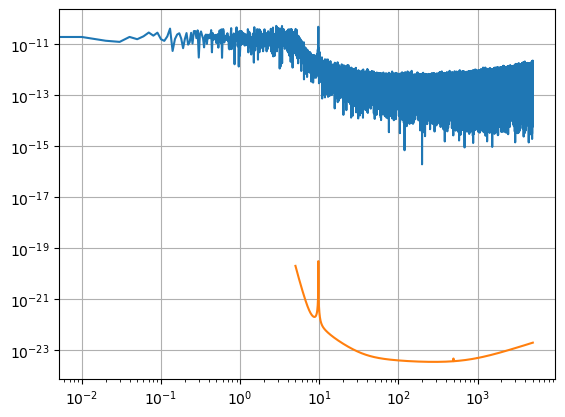

In [35]:
ng = NoiseGenerator()
frequencies = np.loadtxt('LIGOL.txt', dtype='double')[:,0]
psds = np.loadtxt('LIGOL.txt', dtype='double')[:,1]

colour = ng.piecewise_logarithmic(frequencies, psds)

# Number of sample points
N = 1000000
# sample spacing
T = 1.0 / 10000.0


custom = ng.generate(T, N, colour=colour)

yf = fft(custom)
xf = fftfreq(N, T)[:N//2]
import matplotlib.pyplot as plt
plt.loglog(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.loglog(frequencies, psds)

plt.grid()
plt.show()

In [30]:
f = 